## Installs

## Imports

In [ ]:
!git clone https://github.com/ntasfi/PyGame-Learning-Environment
!pip install gym_ple
!pip install -e ./PyGame-Learning-Environment
!pip install pyvirtualdisplay
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev

Cloning into 'PyGame-Learning-Environment'...
remote: Enumerating objects: 1118, done.
remote: Total 1118 (delta 0), reused 0 (delta 0), pack-reused 1118 (from 1)
Receiving objects: 100% (1118/1118), 8.06 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (592/592), done.
  Preparing metadata (setup.py) ... done
  Created wheel for gym_ple: filename=gym_ple-0.3-py3-none-any.whl size=4458 sha256=d13aa4915b1aafd8777fd4ac3786258049a677b1128eb143cde8409faeced7b8
  Stored in directory: /root/.cache/pip/wheels/71/96/17/a59c56c130c89ad5816ef952c93cad65803807f1a3891ba994
Successfully built gym_ple
Obtaining file:///content/PyGame-Learning-Environment
  Preparing metadata (setup.py) ... done
  Running setup.py develop for ple
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev 

In [ ]:
import sys
sys.path.append('/content/PyGame-Learning-Environment')
from ple.games.flappybird import FlappyBird
from ple import PLE
from gym import spaces
import IPython
import numpy as np
import gym
import os
import pyvirtualdisplay
import base64
import warnings
import imageio
from abc import ABC, abstractmethod
warnings.filterwarnings("ignore")


pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


## Utility function to display episode

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Environment

### Environment Summary

This environment simulates the *Flappy Bird* game, where the agent controls the bird’s vertical position to navigate through gaps in pipes. Built on OpenAI’s `gym.Env` class, the environment allows interaction through standard functions like `step`, `reset`, and `render`.

**Key Components**

- **Observation Space**: The observation space includes 8 integer values, each representing a different aspect of the game state. These include:
  - `"player_y"`: The bird's vertical position.
  - `"player_vel"`: The bird's vertical velocity.
  - `"next_pipe_dist_to_player"`: Horizontal distance to the next pipe.
  - Additional features: Positions of the top and bottom of the next two pipes, enabling the agent to anticipate upcoming gaps.

- **Action Space**: This is a discrete space with two actions:
  - `0`: No flap (bird falls due to gravity).
  - `1`: Flap (bird moves upward).
- **Using the Environment**

  - **Step:**
    The `step` function returns four parameters: `obs`, `reward`, `done`, and `info`.

    - **`obs`**: The new observation after applying the action.
    - **`reward`**: The reward received for the action.
    - **`done`**: A boolean indicating whether the episode has ended.
    - **`info`**: A dictionary containing additional information. In this environment, the `info` dictionary includes a `"score"` entry that indicates how many pipes the bird has passed since the beginning of the episode.
  - **Reset**
    The `reset` function restores the environment to its initial state and returns the observation of that state.

  - **Render**
    The `render` function returns an image of the current state as a NumPy array (`np.array`).

  See the `Running the environment` section below for an example of how to use it.

- **Customizable Parameters**:
  - **`pipe_gap`**: This controls the vertical gap between pipes. The default is set to `80`, providing a moderate challenge.
  - **`custom_obs`** and **`custome_observation_map`**: Setting `custom_obs=True` instructs the environment to use a custom `observation_map` specified by the user, rather than the default map. When using a custom observation map, the user must also provide a `preprocess` function compatible with the custom observation map to ensure the observations are correctly processed for the agent.

  - **`preprocess`** and **`reward_shaping`**: Optional functions that allow the user to customize how observations and rewards are modified. The `preprocess` function transforms the raw observations according to the specified `observation_map`, while `reward_shaping` allows for custom adjustments to the reward structure, helping to align the environment with the agent’s learning goals.

  See the `Custom observation and reward shaping example of usage` section below for an example of usage.






In [ ]:
# to disable the python game window popup
os.environ["SDL_VIDEODRIVER"] = "dummy"

OBSERVATION_MAP = {0: 'player_y',
                   1: "player_vel",
                   2: "next_pipe_dist_to_player",
                   3: "next_pipe_top_y",
                   4: "next_pipe_bottom_y",
                   5: "next_next_pipe_dist_to_player",
                   6: "next_next_pipe_top_y",
                   7: "next_next_pipe_bottom_y",
}

class Game(gym.Env):
    def __init__(self, display_screen=False,
                 force_fps=True,
                 custom_obs=False,
                 pipe_gap=80,
                 custome_observation_map={},
                 preprocess=lambda x: x,
                 reward_shaping=lambda x, y, z: x):

        os.environ["SDL_VIDEODRIVER"] = "dummy"
        game = FlappyBird(pipe_gap=pipe_gap)  # define and initiate the environment
        self.env = PLE(game, fps=30, display_screen=display_screen,
                       force_fps=force_fps)
        self.env.init()
        # list of actions in the environment
        self.actions = self.env.getActionSet()
        # length of actions
        self.action_space = spaces.Discrete(len(self.actions))
        self.custom_obs = custom_obs
        self._observation_map = custome_observation_map if custom_obs else OBSERVATION_MAP
        self.preprocess = preprocess
        self.reward_shaping = reward_shaping
        self.score = 0

    @property
    def observation_space(self):
        return spaces.Box(low=0, high=512, shape=(len(self._observation_map),), dtype=int)

    def _get_rgb(self):
        return self.env.getScreenRGB().transpose(1, 0, 2)

    @property
    def observation_map(self):
        return self._observation_map

    def step(self, action):
        """Take the action chosen and update the reward"""
        reward = self.env.act(self.actions[action])
        if reward < 0:
          reward = -1

        if reward > 0:
          self.score += 1
        state = self.env.getGameState()
        terminal = self.env.game_over()
        reward = self.reward_shaping(reward, terminal, env)
        info = {'score':self.score}
        return self.preprocess(np.array(list(state.values())).astype(int)), reward, terminal, info

    def getGameState(self):
        '''
        PLEenv return gamestate as a dictionary. Returns a modified form
        of the gamestate only with the required information to define the state
        '''
        state = self.env.getGameState()
        h_dist = state['next_pipe_dist_to_player']
        v_dist = state['next_pipe_bottom_y'] - state['player_y']
        vel = state['player_vel']

        return ' '.join([str(vel), str(h_dist), str(v_dist)])

    def reset(self):
        """Resets the game to start a new game"""
        self.env.reset_game()
        state = self.env.getGameState()
        self.score = 0
        return self.preprocess(np.array(list(state.values())).astype(int))

    def render(self, mode='human'):
        """Render the game"""
        return self._get_rgb()

    def seed(self, seed):
        rng = np.random.RandomState(seed)
        self.env.rng = rng
        self.env.game.rng = self.env.rng

        self.env.init()

In [ ]:
env = Game(custom_obs=False)

### Observation space

In [ ]:
print(f"observation space: {env.observation_space}")
for feaure, des in env.observation_map.items():
  print(f"feaure: {feaure} -> {des}")

observation space: Box(0, 512, (8,), int64)
feaure: 0 -> player_y
feaure: 1 -> player_vel
feaure: 2 -> next_pipe_dist_to_player
feaure: 3 -> next_pipe_top_y
feaure: 4 -> next_pipe_bottom_y
feaure: 5 -> next_next_pipe_dist_to_player
feaure: 6 -> next_next_pipe_top_y
feaure: 7 -> next_next_pipe_bottom_y


In this *Flappy Bird* environment, the `Box` type represents a `Discrete` observation space in OpenAI's Gym, providing the agent with a range of values in each dimension of the environment. Here’s what each part means:

* **Box**: This type of space is used to define a `Discrete`  range of values for each observation dimension. Here, it represents an 8-dimensional vector.
* **(0, 512)**: Each dimension within this space can take values from 0 to 512, which corresponds to the pixel boundaries of the game.
* **(8,)**: This shape indicates that there are 8 distinct variables in the observation vector, each capturing a critical feature of the environment.
* **int64**: Each value in the vector is an integer of 64-bit precision.

In summary, `Box(0, 512, (8,), int64)` represents an 8-dimensional vector space where each element is an integer from 0 to 512. Each dimension corresponds to a specific aspect of the *Flappy Bird* environment:

1. **Player Y Position**: The vertical position of the bird, representing its height on the screen.
2. **Player Velocity**: The bird’s current velocity, which impacts its movement and helps determine when to flap.
3. **Distance to Next Pipe**: The horizontal distance between the bird and the next pipe, crucial for timing flaps.
4. **Next Pipe Top Y Position**: The vertical position of the top of the next pipe, helping the bird gauge the gap.
5. **Next Pipe Bottom Y Position**: The vertical position of the bottom of the next pipe, providing further data for navigating the gap.
6. **Distance to Next-Next Pipe**: The horizontal distance to the pipe after the next one, giving the bird foresight into upcoming obstacles.
7. **Next-Next Pipe Top Y Position**: The vertical position of the top of the pipe after the next one, extending the bird's view of upcoming gaps.
8. **Next-Next Pipe Bottom Y Position**: The vertical position of the bottom of the pipe after the next one, for additional planning.

Together, these dimensions offer the agent a detailed snapshot of the environment, helping it make decisions based on its position, velocity, and the layout of both current and upcoming obstacles.


### Action space

In [ ]:
env.action_space

Discrete(2)

In this *Flappy Bird* environment, the `Discrete(2)` action space defines the possible actions the agent can take, using a finite set of discrete values:

* **Discrete**: This type of space is used when there are a limited number of distinct actions.
* **2**: The number of actions available, represented by values 0 and 1.

For *Flappy Bird*, these actions correspond to:
  * **0**: Do nothing (the bird continues to fall due to gravity).
  * **1**: Flap (the bird moves upward briefly).

In summary, `Discrete(2)` defines an action space with two possible actions: allowing the bird to either continue falling or flap to move upward, which is essential for navigating the gaps between pipes.


### Rewards

*Reward Structure:*



*   **Positive Reward**: For each pipe successfully passed, the agent receives a reward of **+1**.
*   **Negative Reward**: Upon reaching any terminal state, the agent receives a penalty of **-1**.
*   **Zero Reward**: Any other senario the reward is **0**




### Running the environmen

In [ ]:
env = Game()
env.seed(42)
obs = env.reset()
video_filename = '/content/vid.mp4'
max_steps = 100
# Evaluation
with imageio.get_writer(video_filename, fps=24) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = env.action_space.sample()
      obs, reward, done, info = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      total_reward += reward
      re = env.render()
      video.append_data(re)
      if done:
        score = info['score']
        print("Sum of rewards =", total_reward, ", Number of steps=", step, "score: ", score)
        break
embed_mp4(video_filename)

Sum of rewards = -1.0 , Number of steps= 50 score:  0


### Custom observation and reward shaping example of usage

In [ ]:
custom_obs_mapping = {0: "average",
                      1: 'sum'}

# meaningless preprocess method that average and sums all of the original features
preprocess = lambda x: np.array([np.mean(x), np.sum(x)])

# meaningless reward shaping method that added 1 to each original reward
reward_shaping = lambda x, y, z: x+1

env = Game(custom_obs=True,
           custome_observation_map=custom_obs_mapping,
           preprocess=preprocess,
           reward_shaping=reward_shaping)
env.seed(42)
obs = env.reset()

print(f"observation space: {env.observation_space}")
for feaure, des in env.observation_map.items():
  print(f"feaure: {feaure} -> {des}")

print(f"reset: {obs}")
print("#"*100, end="\n\n")
video_filename = '/content/vid.mp4'
max_steps = 100
# Evaluation
with imageio.get_writer(video_filename, fps=24) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = env.action_space.sample()
      obs, reward, done, info = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      total_reward += reward
      re = env.render()
      video.append_data(re)
      if done:
        score = info['score']
        print("Sum of rewards =", total_reward, ", Number of steps=", step, "score: ", score)
        break
embed_mp4(video_filename)

observation space: Box(0, 512, (2,), int64)
feaure: 0 -> average
feaure: 1 -> sum
reset: [ 197.5 1580. ]
####################################################################################################

Sum of rewards = 42.0 , Number of steps= 42 score:  0


# Your Work begins here

## Preprocess

**Define the `preprocess` Method**

- Create a function called `preprocess` that takes an observation as input.
- The purpose of this function is to transform the raw observation into a format that optimizes learning for the agent. Use your creativity to design an effective preprocessing strategy for this task.

**Suggested Approaches:**
- **Normalization or Scaling**: Adjust observation values to a common range, such as $0$ to $1$ or $0$ to $N$, to improve stability in the learning process.
- **Feature Extraction**: Emphasize key features in the observation that are crucial for achieving the environment's goals.
- **Dimensionality Reduction**: Simplify the observation by removing or combining less significant parts to streamline learning and reduce complexity.

**Compression and Q-Table Size**
- Reducing the complexity of the observation, through techniques like scaling, normalization, or removing redundant features, effectively compresses the data. This compression simplifies the agent’s perception of the environment, helping it focus on the most relevant information.
- In discrete environments, reducing observation dimensionality directly impacts the size of the Q-table. By compressing the observation space, you decrease the number of possible states, which makes the Q-table smaller and easier to manage. This reduction in Q-table size not only conserves memory but can also enhance learning efficiency.
  
Use these ideas to explain how your preprocessing strategy compresses the observation space and helps the agent handle the environment more effectively.

**Rationalize Your Preprocessing Choices**

- Include a brief explanation of your preprocessing choices. Explain why you believe this approach will improve the agent's learning efficiency and performance.
- Discuss how these adjustments make the observations more interpretable or manageable for the learning algorithm.

**Important**
- The maximum value on the **Vertical** axis is **512**.
- The maximum value on the **Horizontal** axis is **288**.


In [ ]:
custome_observation_map = {0: "player_y",
                           1: "player_val",
                           2: "next_pipe_dist_to_player",
                           3: "next_pipe_top_y"} # assing each action with a description of the feature meaning
def preprocess(obs):
  """
  insert your preprocessing code here
  """

  obs = np.array([obs[0], obs[1], obs[2], obs[3]])
  return obs


## Reward shaping

### Define a Reward Shaping Strategy

**Reward shaping** means adjusting the rewards given to the agent to encourage desired actions and help it learn faster. In *Flappy Bird*, the goal is to create rewards that guide the bird to survive longer and avoid hitting pipes.

**Steps for Reward Shaping:**

1. **Identify Desired Behaviors**:
   - Decide which behaviors you want to encourage. For example, flapping at the right time to pass through pipes or avoiding unnecessary flaps could be rewarded.

2. **Design Rewards**:
   - Use rewards that motivate the bird to take helpful actions without distracting from the main goal (staying alive). Here are some ideas:
     - **Survival Reward**: Give a small reward for each step the bird survives.
     - **Penalty for Hitting Pipes**: Apply a negative reward (penalty) when the bird crashes into a pipe.
    - **Passing Through Pipes**: Provide a positive reward each time the bird successfully passes through a pipe.


3. **Explain Your Reward Choices**:
   - Add an explanation for your reward design. Why did you decide to reward certain actions or apply penalties?
   - Describe how your rewards help the bird focus on staying alive and navigating pipes effectively.
   - Provide an example demonstrating the impact of your reward shaping logic, ideally by comparing performance graphs with and without reward shaping.

4. **Avoid Over-Shaping**:
   - Avoid giving too many rewards for minor actions, as it could lead the bird to focus on short-term rewards instead of the main goal. Aim for a balance where the bird gets enough guidance without relying on intermediate rewards.

**Q-Learning and Value Convergence**:
   - Remember, shaping rewards impacts **Q-values** (the expected value of actions). When rewards are well-designed, the bird’s Q-values will better reflect valuable actions, helping it make smarter choices over time.

Use these tips to develop a reward strategy that encourages the bird to navigate through pipes effectively while improving its learning.


In [ ]:
def reward_shaping(reward, terminal, env):
  """
  insert your preprocessing code here
  """
  state = env.getGameState()
  l1 = float(state.split(" ")[2])
  reward = reward * 60 - np.abs(l1/ 255)
  return reward


## Implementation of Learning Agents

Abstract Class for Implementing an On-Policy Agent

Below is an abstract class to serve as a foundation for implementing an on-policy agent. Derive your agent from this class and implement the specific logic for your agent. Note that different agents may require additional parameters or functions to support their unique features and learning mechanisms.


In [ ]:
from abc import ABC, abstractmethod

class OnPolicyAgent(ABC):
    def __init__(self, action_space, observation_space, gamma, learning_rate):
        """
        Initializes the on-policy RL agent.
        You can add more parameters
        Parameters:
        - action_space: The action space of the environment
        - observation_space: The observation space of the environment
        - gamma: Discount factor for future rewards
        - learning_rate: Learning rate for policy updates
        """
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.policy = None  # Placeholder for policy (to be implemented in subclasses)

    @abstractmethod
    def select_action(self, observation, deterministic=False):
        """
        Select an action based on the current policy.

        Parameters:
        - observation: Current state observation from the environment
        -deterministic: Flag indicating whether to use a deterministic policy (default is False)
        Returns:
        - action: Chosen action based on the policy
        """


    @abstractmethod
    def update_policy(self, transition):
        """
        Update the policy based on the current transition.

        Parameters:
        - transition: Data collected from interactions with the environment (tuple of zero or more values such as acion, reward etc...)
        trasition - ([s_i], [a], [s_j], [a_tag], [reward])
        """

    @abstractmethod
    def train(self, env, num_episodes, log_every):
        """
        Train the agent over a specified number of episodes.

        Parameters:
        - env: The environment to train in
        - num_episodes: Number of training episodes
        """


    @abstractmethod
    def save_policy(self, file_path):
        """
        Save the current policy to a file.

        Parameters:
        - file_path: Path to the file where the policy should be saved
        """
        pass

    @abstractmethod
    def load_policy(self, file_path):
        """
        Load a policy from a file.

        Parameters:
        - file_path: Path to the file from which the policy should be loaded
        """
        pass

    @abstractmethod
    def run_policy(self, env):
        """
        Run the loaded policy in the environment for one episode.

        Parameters:
        - env: The environment in which to run the policy

        Returns:
        - total_reward: Total reward accumulated in the episode
        """
        pass


In [ ]:
class MySarsa(OnPolicyAgent):
    def __init__(self, action_space, observation_space, gamma, learning_rate, epsilon=0.1):
        super().__init__(action_space, observation_space, gamma, learning_rate)
        self.policy = np.zeros((*[32] * observation_space.shape[0], action_space.n))
        self.epsilon = epsilon  # Exploration rate

    def select_action(self, observation, deterministic=False):
        """
          Select an action based on the epsilon-greedy strategy.

          Args:
          observation (tuple): The current state or observation.
          deterministic (bool): If True, always select the greedy action (ignore epsilon).

          Returns:
          int: Selected action.
          """

        state = tuple(observation // 16)  # Convert observation to a usable state index if needed
        q_values = self.policy[state]  # Access Q-values for the given state

        if deterministic or np.random.rand() > self.epsilon:
            # Exploit: Choose action with highest Q-value
            action = np.argmax(q_values)
        else:
            # Explore: Choose a random action
            action = np.random.choice(len(q_values))

        return action

    def update_policy(self, transition):
        """
        Update the policy based on the current transition using the SARSA update rule.

        Parameters:
            transition (tuple): A tuple containing:
                - s_i (array-like): Current state.
                - a (int): Current action.
                - s_j (array-like): Next state.
                - a_tag (int): Next action.
                - reward (float): Reward for the transition.

        Updates:
            self.policy: The Q-value for the state-action pair (s_i, a) is updated.
        """
        # Unpack the transition
        s_i, a, s_j, a_tag, reward = transition

        # Convert states to tuples for indexing
        s_i = tuple(s_i // 16)
        s_j = tuple(s_j // 16)

        # SARSA update
        self.policy[s_i][a] += self.learning_rate * (
            reward + self.gamma * self.policy[s_j][a_tag] - self.policy[s_i][a]
        )
    def train(self, env, num_episodes, log_every):
        """
        Train the agent using SARSA.

        Args:
            env (gym.Env): The environment to train the agent in.
            num_episodes (int): Number of episodes to train for.
            log_every (int): Frequency of logging episode statistics.
        """
        max_steps = 2000
        episode_rewards = []
        episode_scores = []
        success_count = []  # To track successful episodes (reaching 10 pipes)

        for episode in range(num_episodes):
            obs = env.reset()
            done = False
            total_reward = 0
            action = self.select_action(obs)
            pipe_count = 0  # Count of pipes cleared in this episode
            info = {}
            for step in range(max_steps):
                prev_obs = obs
                obs, reward, done, info = env.step(action)

                total_reward += reward

                # Count pipes cleared (assumes 'score' tracks pipes passed)
                pipe_count = info.get('score', pipe_count)

                # Select the next action
                a_tag = self.select_action(obs)

                # Create transition
                transition = (prev_obs, action, obs, a_tag, reward)
                self.update_policy(transition)

                # Update the action
                action = a_tag

                if done:
                    break

            score = info.get('score', 0)
            episode_scores.append(score)

            # Determine if the episode is successful
            success = 1 if pipe_count >= 10 else 0
            success_count.append(success)

            episode_rewards.append(total_reward)

            # Logging
            if episode % log_every == 0 or episode == num_episodes - 1:
                print(f"Episode {episode + 1}/{num_episodes}: "
                      f"Total Reward = {total_reward:.2f}, "
                      f"Steps = {step}, Score = {score}, Success = {success}")

            if episode % (num_episodes // 10) == 0: #every 10% of the loop
                directory_path = f'content/{self.__class__.__name__}_ep={self.epsilon}_ga={self.gamma}_lr={self.learning_rate}'
                os.makedirs(directory_path, exist_ok=True)  # Create the directory if it doesn't exist

                self.run_policy(env,embed=True,fname=f'{directory_path}/{episode}.mp4')

        return episode_rewards, success_count, episode_scores

    def save_policy(self, file_path):
        """
        Save the current policy to a file.

        Parameters:
            file_path (str): Path to the file where the policy should be saved.
        """
        np.save(file_path, self.policy)
        print(f"Policy saved to {file_path}")

    def load_policy(self, file_path):
        """
        Load a policy from a file.

        Parameters:
            file_path (str): Path to the file from which the policy should be loaded.
        """
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Policy file not found: {file_path}")
        self.policy = np.load(file_path)

    def run_policy(self, env,embed=False,fname="vid.mp4"):
        """
        Run the loaded policy in the environment for one episode.

        Parameters:
            env: The environment in which to run the policy.

        Returns:
            float: Total reward accumulated in the episode.
        """
        video = {}
        if embed:
           video = imageio.get_writer(fname, fps=24)

        obs = env.reset()
        done = False
        score = 0
        max_steps = 2000

        for _ in range(max_steps):
            action = self.select_action(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            score = info.get('score', 0)

            if embed:
              re = env.render()
              video.append_data(re)
            if done:
                break
        if embed:
          embed_mp4(fname)
          video.close()
        return score


In [ ]:
class MyQLearning(MySarsa):
    def __init__(self, action_space, observation_space, gamma, learning_rate, epsilon=0.1):
        """
        Initialize the Q-Learning agent.

        Args:
            action_space (int): Number of possible actions.
            observation_space (tuple): Shape of the state space.
            gamma (float): Discount factor for future rewards.
            learning_rate (float): Learning rate for Q-value updates.
            epsilon (float): Exploration rate for epsilon-greedy policy.
        """
        super().__init__(action_space, observation_space, gamma, learning_rate)

    def update_policy(self, transition):
        """
        Update the policy based on the current transition using the Q-Learning update rule.

        Parameters:
            transition (tuple): A single tuple containing:
                - s_i (array-like): Current state.
                - a (int): Current action.
                - s_j (array-like): Next state.
                - reward (float): Reward for the transition.
        """
        # Unpack the transition
        s_i, a, s_j,a_tag, reward = transition

        # Convert states to tuples for indexing
        s_i = tuple(s_i // 16)
        s_j = tuple(s_j // 16)

        # Q-Learning update rule
        max_q_next = np.max(self.policy[s_j])  # Maximum Q-value for the next state
        self.policy[s_i][a] += self.learning_rate * (
            reward + self.gamma * max_q_next - self.policy[s_i][a]
        )

## Training

#### Experimentation Instructions

In this section, you will conduct a series of experiments to solve the environment using your on-policy agent. Follow these guidelines for a clear and comprehensive presentation of your work:

1. **Design and Run Experiments**:
   - Perform at least **5 distinct experiments** with your agent, including:
     - **2 unsuccessful experiments** where the agent fails to learn the environment (reaching a score below the target).
     - **1 successful experiment** where the agent achieves a score of **10** or higher. (Remember the score is define by the amount of pipes the agent has passed)

   - *Note*: In practice, you are expected to try many configurations to observe various outcomes, even beyond these 3 experiments.

2. **Provide Detailed Summaries**:
   - For each experiment, include:
     - **Graphs** that illustrate the training process, such as reward progression, steps, score, and  any other relevant metrics (there is many more metrics that we can learn from).
     - **Explanations of Hyperparameters**: Clearly describe the configuration of hyperparameters chosen for each experiment, and the reasoning behind these choices.
     - **Preprocessing and Reward Shaping**: Explain any data preprocessing or reward shaping techniques applied, along with the motivation for these techniques.

3. **Analyze and Reflect**:
   - **Result Analysis**: Analyze each experiment's outcome, focusing on why the agent may have succeeded or failed based on your configurations.
   - **Insights and Deductions**: Draw insights from each experiment, noting what worked and what didn’t. Use these insights to refine your understanding of the environment and agent performance.

4. **Final Report**:
   - **Synthesize Findings**: Compile all observations, insights, and analysis from your experiments into a final report. This report should showcase your learnings and demonstrate a deep understanding of the experimentation process.
   - **Emphasis on Analysis**: The analysis of your results and the conclusions drawn are the most critical aspects of this exercise. Dedicate ample attention to this section, as it will reflect your ability to interpret and understand the agent’s learning process.

**Remember**: The goal of this exercise is to experiment, learn, and iterate. Document your process thoroughly, as this will form the foundation of your report.


In [15]:
import itertools
import pickle

# Function to run and save training data for a given model
def train_and_save_model(model, env, model_type, run_number, hyperparameters, episode_count=80000, eval_interval=10000):
    episode_rewards, success_count, episode_scores = model.train(env, episode_count, eval_interval)

    # Save the training results and hyperparameters
    data_to_save = {
        'episode_rewards': episode_rewards,
        'success_count': success_count,
        'episode_scores': episode_scores,
        'hyperparameters': hyperparameters  # Directly store the hyperparameters here
    }

    # Save the data with a unique file name based on model type and run number
    file_name = f"content/{model_type}_{run_number}_data.pkl"
    with open(file_name, "wb") as file:
        pickle.dump(data_to_save, file)
    print(f"Training data for {model_type} (Run {run_number}) saved to '{file_name}'.")

gamma_values = [0.95]
learning_rate_values = [0.1]
epsilon_values = [0.1]

hyperparameters_grid = list(itertools.product(gamma_values, learning_rate_values, epsilon_values))

hyperparameters_list = [
    {'gamma': gamma, 'learning_rate': learning_rate, 'epsilon': epsilon}
    for gamma, learning_rate, epsilon in hyperparameters_grid
]

# Function to run the SARSA training with a specific run number
def run_sarsa(params, run_number):
    env = Game(custom_obs=True, preprocess=preprocess, reward_shaping=reward_shaping, custome_observation_map=custome_observation_map)
    sarsa_model = MySarsa(
        action_space=env.action_space,
        observation_space=env.observation_space,
        gamma=params['gamma'],
        learning_rate=params['learning_rate'],
        epsilon=params['epsilon']
    )
    # Train and save SARSA model results with different hyperparameters
    train_and_save_model(sarsa_model, env, "Sarsa", run_number, params)
    # Save the SARSA model policy
    sarsa_model.save_policy(f"content/Sarsa_model_run_{run_number}")

# Function to run the Q-learning training with a specific run number
def run_qlearning(params, run_number):
    env = Game(custom_obs=True, preprocess=preprocess, reward_shaping=reward_shaping, custome_observation_map=custome_observation_map)
    qlearning_model = MyQLearning(
        action_space=env.action_space,
        observation_space=env.observation_space,
        gamma=params['gamma'],
        learning_rate=params['learning_rate'],
        epsilon=params['epsilon']
    )
    # Train and save Q-learning model results with different hyperparameters
    train_and_save_model(qlearning_model, env, "Qlearning", run_number, params)
    # Save the Q-learning model policy
    qlearning_model.save_policy(f"content/Qlearning_model_run_{run_number}")


for i, params in enumerate(hyperparameters_list):
    run_sarsa(params,i)

for i, params in enumerate(hyperparameters_list):
    run_qlearning(params,i)


Episode 1/80000: Total Reward = -100.60, Steps = 61, Score = 0, Success = 0
Episode 10001/80000: Total Reward = 55.57, Steps = 189, Score = 4, Success = 0
Episode 20001/80000: Total Reward = -47.15, Steps = 71, Score = 1, Success = 0
Episode 30001/80000: Total Reward = 606.25, Steps = 814, Score = 20, Success = 1
Episode 40001/80000: Total Reward = -64.18, Steps = 97, Score = 1, Success = 0
Episode 50001/80000: Total Reward = 198.64, Steps = 337, Score = 8, Success = 0
Episode 60001/80000: Total Reward = -27.76, Steps = 133, Score = 2, Success = 0
Episode 70001/80000: Total Reward = -12.69, Steps = 110, Score = 2, Success = 0
Episode 80000/80000: Total Reward = 216.73, Steps = 401, Score = 9, Success = 0
Training data for Sarsa (Run 0) saved to 'content/Sarsa_0_data.pkl'.
Policy saved to content/Sarsa_model_run_0
Episode 1/80000: Total Reward = -99.29, Steps = 59, Score = 0, Success = 0
Episode 10001/80000: Total Reward = 5.39, Steps = 174, Score = 3, Success = 0
Episode 20001/80000: T

##Plot -
1. Episodes vs. Normalized Rewards
2. Episodes vs. Success Rate

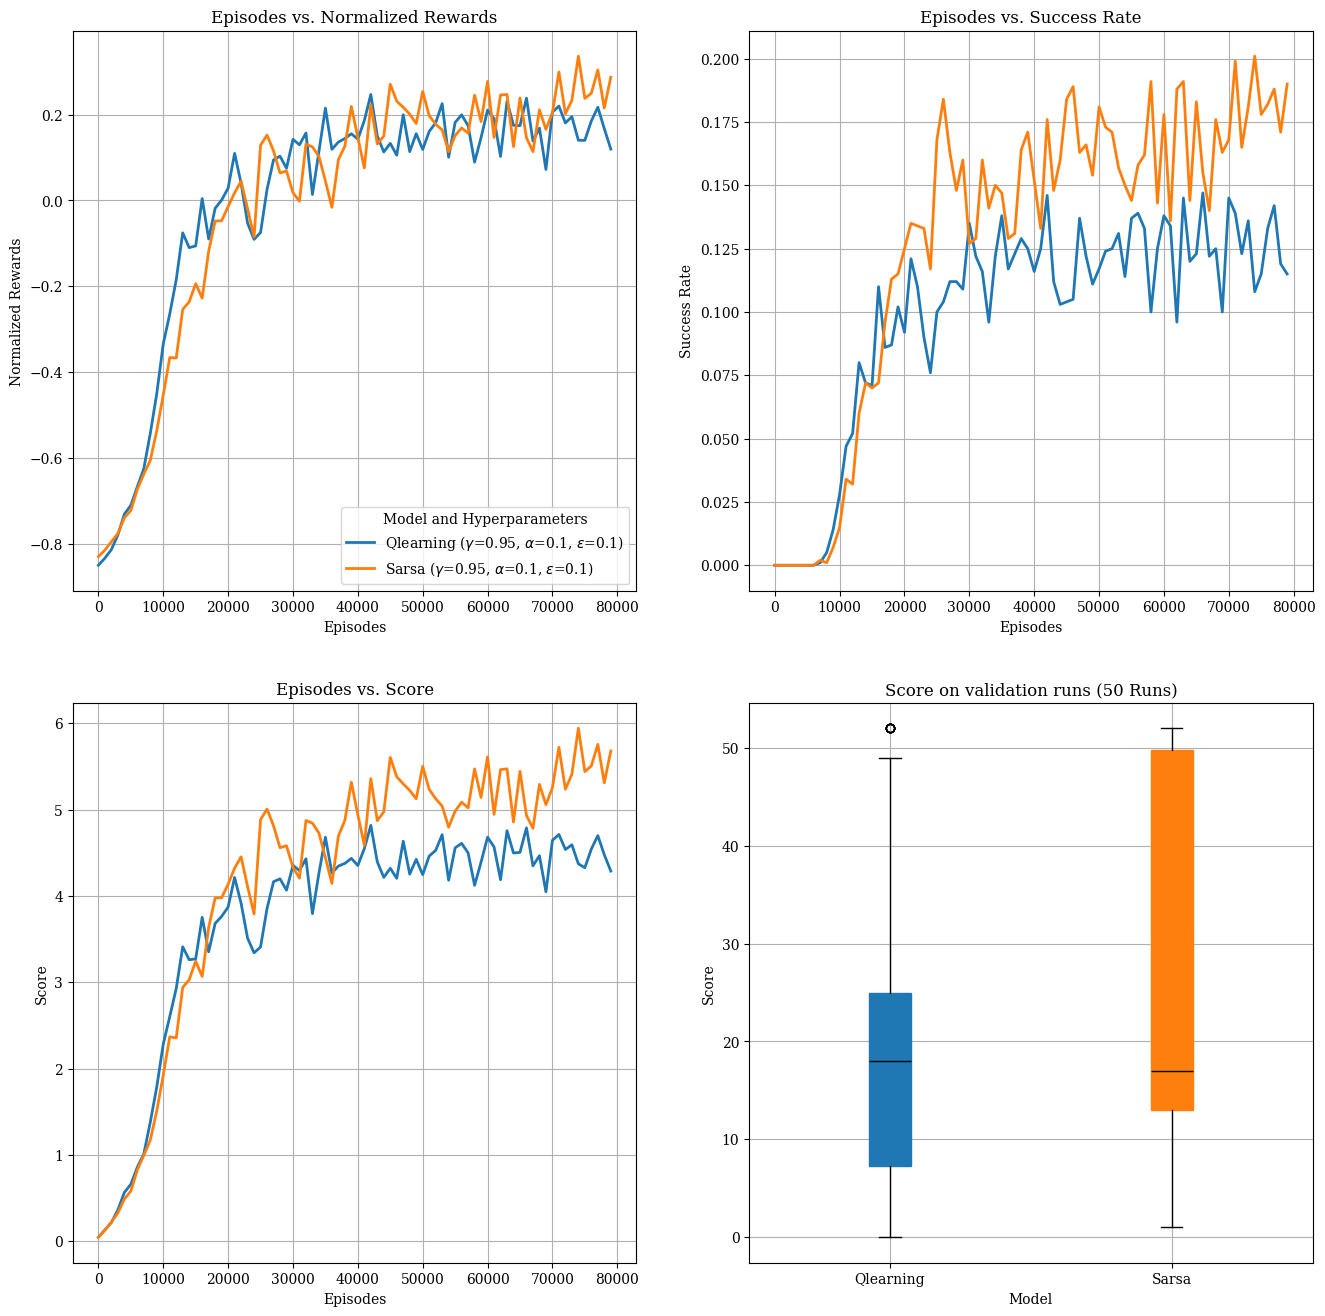

In [18]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

def compute_average_and_variance(data, k):
    """
    Calculate the mean and variance of elements of a list in windows of size k.

    Args:
        data (list or numpy array): Data to be averaged and for variance calculation.
        k (int): Window size for averaging.

    Returns:
        tuple: Averaged data and corresponding variance data.
    """
    avg = []
    var = []
    for i in range(0, len(data), k):
        segment = data[i:i + k]
        avg.append(np.mean(segment))
        var.append(np.std(segment))  # Standard deviation as variance
    return np.array(avg), np.array(var)

def plot_multiple_datasets(file_paths, k=1000, plot_variance=False,L=20):
    """
    Plot multiple datasets loaded from pickle files with optional variance bands (shaded area).

    Args:
        file_paths (list of str): List of file paths to the pickle files.
        k (int): Window size for averaging and variance calculation
        plot_variance (bool): If True, plot the variance bands around the average line.
    """
    fig, ax = plt.subplots(2, 2, figsize=(16, 16))

    legend_handles = []
    legend_labels = []

    # Define a list of colors for different models
    colors = plt.cm.tab10.colors

    # Loop through each file and plot data
    for idx, file_path in enumerate(file_paths):
        with open(file_path, "rb") as file:
            loaded_data = pickle.load(file)

        episode_rewards = loaded_data['episode_rewards']
        success_count = loaded_data['success_count']
        episode_scores = loaded_data.get('episode_scores', [])

        # Extract model name from file name (first part before an underscore or delimiter)
        model_name = os.path.basename(file_path).split('_')[0]

        # Extract hyperparameters from the loaded data
        hyperparameters = loaded_data.get('hyperparameters', {})

        # Format hyperparameters with Greek symbols
        hyperparam_str = ", ".join([
            f"$\\gamma$={hyperparameters.get('gamma', 'N/A')}",
            f"$\\alpha$={hyperparameters.get('learning_rate', 'N/A')}",
            f"$\\epsilon$={hyperparameters.get('epsilon', 'N/A')}"
        ])

        legend_label = f"{model_name} ({hyperparam_str})"

        color = colors[idx % 10]

        # Normalize rewards
        normalized_rewards = (episode_rewards - np.mean(episode_rewards)) / np.std(episode_rewards)

        # Compute average values (and variance if needed)
        normalized_rewards_avg, normalized_rewards_var = compute_average_and_variance(normalized_rewards, k)
        success_rate_avg, success_rate_var = compute_average_and_variance(np.array(success_count), k)

        if episode_scores:
            episode_score_rate, episode_score_var = compute_average_and_variance(np.array(episode_scores), k)

        # Subplot 1: Episodes vs. Normalized Rewards
        ax[0,0].plot(range(1, len(episode_rewards) + 1, k), normalized_rewards_avg, label=legend_label, color=color, linewidth=2)
        if plot_variance:
            ax[0,0].fill_between(range(1, len(episode_rewards) + 1, k),
                              normalized_rewards_avg - normalized_rewards_var,
                              normalized_rewards_avg + normalized_rewards_var,
                              color=color, alpha=0.3)

        ax[0,0].set_xlabel("Episodes")
        ax[0,0].set_ylabel("Normalized Rewards")
        ax[0,0].set_title("Episodes vs. Normalized Rewards")
        ax[0,0].grid(True)

        # Subplot 2: Episodes vs. Success Rate
        ax[0,1].plot(range(1, len(success_count) + 1, k), success_rate_avg, label=legend_label, color=color, linewidth=2)
        if plot_variance:
            ax[0,1].fill_between(range(1, len(success_count) + 1, k),
                              success_rate_avg - success_rate_var,
                              success_rate_avg + success_rate_var,
                              color=color, alpha=0.3)

        ax[0,1].set_xlabel("Episodes")
        ax[0,1].set_ylabel("Success Rate")
        ax[0,1].set_title("Episodes vs. Success Rate")
        ax[0,1].grid(True)

        # Subplot 3: Episodes vs. Score
        if episode_scores:
            ax[1,0].plot(range(1, len(episode_scores) + 1, k), episode_score_rate, label=legend_label, color=color, linewidth=2)
            if plot_variance:
                ax[1,0].fill_between(range(1, len(episode_scores) + 1, k),
                                  episode_score_rate - episode_score_var,
                                  episode_score_rate + episode_score_var,
                                  color=color, alpha=0.3)

        ax[1,0].set_xlabel("Episodes")
        ax[1,0].set_ylabel("Score")
        ax[1,0].set_title("Episodes vs. Score")
        ax[1,0].grid(True)

        legend_handles.append(ax[0,0].lines[-1])
        legend_labels.append(legend_label)

    # Combine the legends from all subplots into one
    ax[0,0].legend(handles=legend_handles, labels=legend_labels, title="Model and Hyperparameters")

    # Prepare data for the boxplot
    scores = []
    box_colors = []  # List to store boxplot colors for each model
    for idx, file_path in enumerate(file_paths):
        model_name = os.path.basename(file_path).split('_')[0]
        run_number = file_path.split('_')[1]

        # Load model policy from the numpy file
        policy_file = f"content/{model_name}_model_run_{run_number}.npy"

        # Create the environment
        env = Game(custom_obs=True, preprocess=preprocess, reward_shaping=reward_shaping, custome_observation_map=custome_observation_map)

        # Initialize the model based on the type (SARSA or Qlearning)
        if model_name.lower() == "sarsa":
            model = MySarsa(
                action_space=env.action_space,
                observation_space=env.observation_space,
                gamma=hyperparameters.get('gamma', 0.95),
                learning_rate=hyperparameters.get('learning_rate', 0.1),
                epsilon=hyperparameters.get('epsilon', 0.1)
            )
        elif model_name.lower() == "qlearning":
            model = MyQLearning(
                action_space=env.action_space,
                observation_space=env.observation_space,
                gamma=hyperparameters.get('gamma', 0.95),
                learning_rate=hyperparameters.get('learning_rate', 0.1),
                epsilon=hyperparameters.get('epsilon', 0.1)
            )
        model.load_policy(policy_file)  # Load the policy

        # Run the policy L times and collect success rates
        run_scores = []
        for _ in range(L):
            success = model.run_policy(env)
            run_scores.append(success)

        scores.append(run_scores)
        box_colors.append(colors[idx % 10])  # Add the corresponding color for the boxplot

    # Create the boxplot with colors for each model
    bp = ax[1,1].boxplot(scores, patch_artist=True, medianprops=dict(color='black'))

    # Set box colors individually for each model
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
    ax[1,1].set_xlabel("Model")
    ax[1,1].set_ylabel("Score")
    ax[1,1].set_title(f"Score on validation runs ({L} Runs)")
    ax[1,1].set_xticklabels([os.path.basename(file_path).split('_')[0] for file_path in file_paths])
    ax[1,1].grid(True)

file_list = [f"content/Qlearning_{i}_data.pkl" for i in range(0,1)] + [f"content/Sarsa_{i}_data.pkl" for i in range(0,1)]
plot_multiple_datasets(file_list,L=50)
plt.savefig("content/easy_plot",dpi=300)



## Validation

#### Validation Section

In this section, you will validate your agent’s performance using the best-performing configuration identified in the experimentation phase. This validation step should be less exhaustive than the experimentation section but should provide sufficient evidence of your agent's consistency and stability.

1. **Run Validation Trials**:
   - Using the chosen configuration, run the agent in the environment for **multiple trials** (e.g., 5-10 episodes) to test its reliability.
   - Observe the agent's performance across these trials to confirm whether it consistently achieves or exceeds the target score of 10.

2. **Provide Key Summaries**:
   - **Performance Metrics**: Summarize the agent’s performance with key metrics such as average score, highest score, and variance across trials.
   - **Graphs** (Optional): Include basic graphs showing score progression or any other relevant metric, if they provide additional insight into the agent's stability.

3. **Brief Analysis**:
   - Reflect on the agent's performance in validation. Note any patterns or inconsistencies and provide a short explanation of how these results align (or differ) from your expectations based on the experimentation phase.

*Note*: This validation section should confirm and strengthen the results of your experimentation, focusing on reliability and consistency rather than extensive analysis.

*Note*: Store the agent's policy to files since you asked to provide aditional notbook that loads the agent policy


In [20]:
env = Game(custom_obs=True, preprocess=preprocess, reward_shaping=reward_shaping, custome_observation_map=custome_observation_map)
model = MySarsa(action_space=env.action_space,observation_space=env.observation_space,gamma=0.95,learning_rate=0.1)
model.load_policy("content/Sarsa_model_run_0.npy")

with imageio.get_writer(video_filename, fps=24) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(4000):
      action = model.select_action(obs, deterministic=True)
      obs, reward, done, info = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      total_reward += reward
      re = env.render()
      video.append_data(re)
      if done:
        score = info['score']
        print("Sum of rewards =", total_reward, ", Number of steps=", step, "score: ", score)
        break
embed_mp4(video_filename)

Sum of rewards = 764.1294117647053 , Number of steps= 662 score:  16


The validation runs are provided in the boxplot, based on the result of the general case (and the hard mode pipe=65 models that were trained seperately) we observe that failure is mostly caused by a steep rise between pipes. One possible solution is to use the next_next information, but it will be more computationly intensive.
In This case we also observe that Q_learning was more concentrated around its median, and proformed overall better the Sarsa, its behavior also was more "decisive" and jumped continously unlike Sarsa.

In [35]:
with open("content/Sarsa.pkl", "wb") as file:
    pickle.dump(model,file)
with open("content/Qlearning.pkl", "wb") as file:
    model = MyQLearning(action_space=env.action_space,observation_space=env.observation_space,gamma=0.95,learning_rate=0.1)
    model.load_policy("content/Qlearning_model_run_0.npy")
    pickle.dump(model,file)